<a href="https://colab.research.google.com/github/PythonDSBook/notebooks/blob/main/Chapter11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 第11章 モデル選択

## 11.4 交差検証によるモデル選択の例

### 11.1 ライブラリのインポート

In [ ]:
!pip install japanize_matplotlib

In [2]:
import japanize_matplotlib

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [4]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate

### コード 11.2 訓練データとテストデータ

In [5]:
california = fetch_california_housing()
X = california.data
y = california.target
X_train, X_test, y_train, y_test = train_test_split(
  X, y, test_size=0.2, random_state=10
)

In [6]:
california = fetch_california_housing()
X = california.data
y = california.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

### コード 11.3 外れ値の処理

In [7]:
feature = 0
X_train = X_train[:, feature]
X_test = X_test[:, feature]
q1 = np.percentile(X_train, 25)
q3 = np.percentile(X_train, 75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr
mask_train = (
  (X_train >= lower_bound) & (X_train <= upper_bound)
)
mask_test = (
  (X_test >= lower_bound) & (X_test <= upper_bound)
)
X_train = X_train[mask_train].reshape(-1, 1)
y_train = y_train[mask_train]
X_test = X_test[mask_test].reshape(-1, 1)
y_test = y_test[mask_test]

### コード 11.4 多項式の特徴の生成

In [8]:
features = PolynomialFeatures(degree=3, include_bias=False)
features.fit_transform([[2], [5], [8]])

array([[  2.,   4.,   8.],
       [  5.,  25., 125.],
       [  8.,  64., 512.]])

### コード 11.5 多項式の次数を変えたときの交差検証

In [9]:
train_mse = []
valid_mse = []

for degree in range(1, 16):
  model = make_pipeline(
    StandardScaler(),
    PolynomialFeatures(degree=degree, include_bias=False),
    LinearRegression()
  )
  scores = cross_validate(
    model, X_train, y_train, cv=5,
    scoring='neg_mean_squared_error',
    return_train_score=True
  )
  train_mse.append(-scores['train_score'].mean())
  valid_mse.append(-scores['test_score'].mean())

### 図 11.7

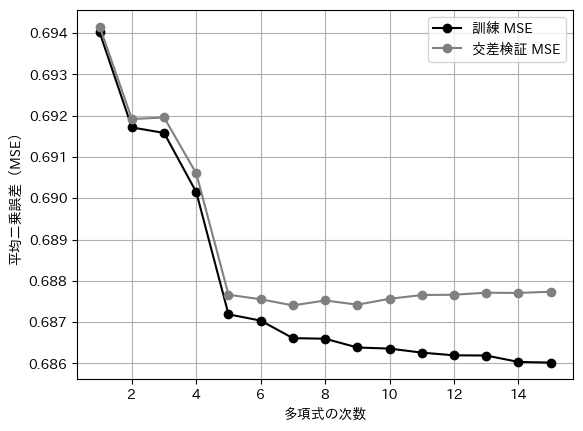

In [10]:
plt.plot(range(1, 16), train_mse, marker='o', label='訓練 MSE', c='k')
plt.plot(range(1, 16), valid_mse, marker='o', label='交差検証 MSE', c='gray')
plt.xlabel('多項式の次数')
plt.ylabel('平均二乗誤差（MSE）')
plt.legend()
plt.grid(True)
plt.show()

### コード 11.6 正則化係数を変えたときの交差検証

In [11]:
train_mse = []
valid_mse = []
degree = 9

for alpha in np.logspace(-3, 3, 7):
  model = make_pipeline(
    StandardScaler(),
    PolynomialFeatures(include_bias=False, degree=degree),
    Ridge(alpha=alpha)
  )
  scores = cross_validate(
      model, X_train, y_train, cv=5,
      scoring='neg_mean_squared_error',
      return_train_score=True
  )
  train_mse.append(-scores['train_score'].mean())
  valid_mse.append(-scores['test_score'].mean())

### 図 11.8

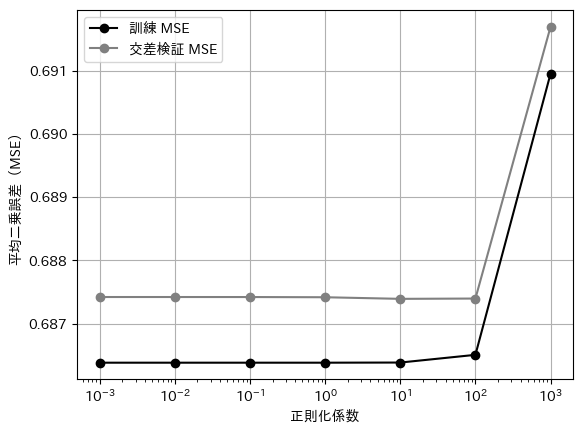

In [12]:
plt.plot(np.logspace(-3, 3, 7), train_mse, marker='o', label='訓練 MSE', c='k')
plt.plot(np.logspace(-3, 3, 7), valid_mse, marker='o', label='交差検証 MSE', c='gray')
plt.xscale('log')
plt.xlabel('正則化係数')
plt.ylabel('平均二乗誤差（MSE）')
plt.legend()
plt.grid(True)
plt.show()

### コード 11.7 ハイパーパラメータのグリッドサーチによる交差検証

In [13]:
model = make_pipeline(
  StandardScaler(),
  PolynomialFeatures(include_bias=False),
  Ridge()
)
param_grid = {
  'polynomialfeatures__degree': np.arange(1, 15),
  'ridge__alpha': np.logspace(-3, 3, 7)
}
best_model = GridSearchCV(
  model,
  param_grid=param_grid,
  cv=5,
  scoring='neg_mean_squared_error'
)
best_model.fit(X_train, y_train)
print('Best parameters: ', best_model.best_params_)

Best parameters:  {'polynomialfeatures__degree': 9, 'ridge__alpha': 10.0}


### コード 11.8 モデルの学習とテストデータによる評価

In [14]:
train_score = best_model.score(X_train, y_train)
test_score = best_model.score(X_test, y_test)
print(f'train score: {-train_score:.3f}')
print(f'test score: {-test_score:.3f}')

train score: 0.686
test score: 0.695
